# Emotion Recognition Model Validation

The main objective of this notebook is to validate the trained model for emotion recognition

In [1]:
# Add project path to the PYTHONPATH

import os
import sys
from pathlib import Path

sys.path.append(Path(os.path.join(os.path.abspath(''), '../')).resolve().as_posix())

In [2]:
import pickle

## Load Tokenizer

Load `.pickle` file with the tokenizer

In [3]:
tokenizer_path = Path('../datasets/sentiment_analysis/tokenizer.pickle').resolve()
with tokenizer_path.open('rb') as file:
    tokenizer = pickle.load(file)

## Load Model

Load the trained emotion recognition model

In [4]:
from emotion_recognition.models.lstm_conv_model import lstm_conv_model

In [5]:
model_weights_path = Path('../models/emotion_recognition/model_weights.h5').resolve()
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
model = lstm_conv_model(100, input_dim, 4, embedding_dim=500)
model.load_weights(model_weights_path.as_posix())

W0717 11:15:09.522073 4369262016 deprecation.py:506] From /Users/rmohashi/miniconda3/envs/emodata/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0717 11:15:09.610648 4369262016 deprecation.py:506] From /Users/rmohashi/miniconda3/envs/emodata/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0717 11:15:09.623605 4369262016 deprecation.py:506] From /Users/rmohashi/miniconda3/envs/emodata/lib/python3.6/site-packages/tensorflow/python/ops/init_op

## Load test dataset

Load the dataset that will be used to test the model

In [6]:
import pandas as pd

In [7]:
test_data_path = Path('../datasets/sentiment_analysis/test.csv').resolve()
test_data = pd.read_csv(test_data_path)

In [8]:
test_data.head()

,label,id,date,user,text
0,fear,1151474078131339264,2019-07-17 12:49:48,13thSnipers,It's so obvious Ashley Young @youngy18 is not ...
1,fear,1151474075723870208,2019-07-17 12:49:47,ShukrahFirdaus,Engaging in a staring competition with this wo...
2,fear,1151473913668313089,2019-07-17 12:49:09,EvinErvian,@savage2ooo yah me too. worst? can't stand wat...
3,fear,1151473830398976000,2019-07-17 12:48:49,oliviaakuhn,i was with @regiannoni EXACTLY 2 years and 3 y...
4,fear,1151473618318176257,2019-07-17 12:47:58,zaaboogie_,This heat different 😰


## Load Encoder

Load `.pickle` file with the encoder

In [9]:
encoder_path = Path('../models/emotion_recognition/encoder.pickle').resolve()
with encoder_path.open('rb') as file:
    encoder = pickle.load(file)

## Preprocess data

Preprocess the data that will be used

In [10]:
from nlp.utils import preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rmohashi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
test_data['text'] = preprocess(test_data.text)
sequences = [text.split() for text in test_data.text]
list_tokenized = tokenizer.texts_to_sequences(sequences)
x_test = pad_sequences(list_tokenized, maxlen=100)
y_test = encoder.transform(test_data.label)

Time to clean up: 0.66 sec


## Results

Predict the labels and generate a confusion matrix

In [12]:
y_pred = model.predict(x_test)

In [13]:
y_pred = y_pred.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return fig, ax

Normalized confusion matrix
[[0.89105058 0.07003891 0.         0.03891051]
 [0.16734694 0.7755102  0.00816327 0.04897959]
 [0.0141844  0.0248227  0.95744681 0.0035461 ]
 [0.10780669 0.04832714 0.01858736 0.82527881]]


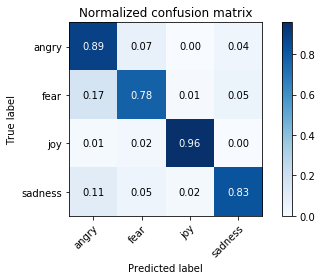

In [16]:
fig, ax = plot_confusion_matrix(y_test, y_pred, encoder.classes_, normalize=True)
fig.savefig('confusion_matrix.png')